In [197]:
import pandas as pd  
import numpy as np
import math
import statsmodels as sm
import seaborn as sns
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)
import matplotlib.pyplot as plt


# import custom functions
import sys
sys.path.append("../")
import mcc_metastasis.data_cleaning as dc


### Filter data for features of interest
- 6 features (excluding tumor_depth and immuno suppressed) 

In [198]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv") 

# fix up some features
df['AGE'] = df.AGE.astype('float')
df['TNM_negative'] = df.TNM_positive.replace({0:1, 1:0})
df['tumor_site'] = df.tumor_site.astype("category")

# select only features for analysis
df = df[['TNM_negative', 'AGE', 'tumor_size', 'tumor_site', 'SEX', 
              'growth_pattern', 'tumor_lymphocytes', 'lymph_vasc_invasion']]


# apply one-hot encoding 
one_hot_tumor_site = pd.get_dummies(df.tumor_site, prefix = 'tumor_site', drop_first =True)
df = df.drop(columns = ['tumor_site'])
df = pd.concat([df, one_hot_tumor_site], axis = 1)



## 1. Data iterations
### Dataset option 1: with growth pattern included
- already decided to remove immuno_suppressed 

In [199]:
df1 = df

### Filter data for only cases with valid outcome 

In [200]:
# only include valid cases for outcome
print("Total for MCC: %0.f" % len(df1))
df1 = df1[(df1.TNM_negative.notnull())]
print("Total N with outcome: %0.f" % len(df1))
df1_complete = df1.dropna(axis = 0)
print("Complete cases: %0.f" % len(df1_complete))
display(dc.get_missingness_table(df1))

Total for MCC: 14948
Total N with outcome: 6201
Complete cases: 669
Missingness of features


,index,Missing
0,TNM_negative,0
1,AGE,0
2,tumor_size,988
3,SEX,0
4,growth_pattern,5156
5,tumor_lymphocytes,4464
6,lymph_vasc_invasion,3314
7,tumor_site_head_neck,0
8,tumor_site_other,0
9,tumor_site_trunk,0


In [201]:

df1 = df1[(df1.TNM_negative.notnull()) & (df1.lymph_vasc_invasion.notnull())]
print("Total N with outcome and LVI: %0.f" % len(df1))
df1_complete = df1.dropna(axis = 0)
print("Complete cases: %0.f" % len(df1_complete))
display(dc.get_missingness_table(df1))

Total N with outcome and LVI: 2887
Complete cases: 669
Missingness of features


,index,Missing
0,TNM_negative,0
1,AGE,0
2,tumor_size,263
3,SEX,0
4,growth_pattern,1998
5,tumor_lymphocytes,1555
6,lymph_vasc_invasion,0
7,tumor_site_head_neck,0
8,tumor_site_other,0
9,tumor_site_trunk,0


In [202]:
features1 = df1.drop(columns = ['TNM_negative'])
outcome1 = df1['TNM_negative'].reset_index(drop = True)


### Dataset option 2: without growth 

In [203]:
df2 = df.drop(columns = ['growth_pattern'])
df2.columns

Index(['TNM_negative', 'AGE', 'tumor_size', 'SEX', 'tumor_lymphocytes',
       'lymph_vasc_invasion', 'tumor_site_head_neck', 'tumor_site_other',
       'tumor_site_trunk'],
      dtype='object')

#### Filter for only data with valid outcome 

In [204]:
# only include valid cases for outcome
print("Total for MCC: %0.f" % len(df2))
df2 = df2[(df2.TNM_negative.notnull())]
print("Total N with outcome: %0.f" % len(df2))
df2_complete = df2.dropna(axis = 0)
print("Complete cases: %0.f" % len(df2_complete))
display(dc.get_missingness_table(df2))

Total for MCC: 14948
Total N with outcome: 6201
Complete cases: 1235
Missingness of features


,index,Missing
0,TNM_negative,0
1,AGE,0
2,tumor_size,988
3,SEX,0
4,tumor_lymphocytes,4464
5,lymph_vasc_invasion,3314
6,tumor_site_head_neck,0
7,tumor_site_other,0
8,tumor_site_trunk,0


In [205]:
features2 = df2.drop(columns = ['TNM_negative'])
outcome2 = df2['TNM_negative'].reset_index(drop = True)

## 2. Imputation for missing data 

### Method 1:  Iterative Imputer in sklearn
- Sklean versionof MICE  method
- provides continuous estimates, but binarize at 0.5

Our implementation of IterativeImputer was inspired by the R MICE package (Multivariate Imputation by Chained Equations) 1, but differs from it by returning a single imputation instead of multiple imputations. However, IterativeImputer can also be used for multiple imputations by applying it repeatedly to the same dataset with different random seeds when sample_posterior=True. See 2, chapter 4 for more discussion on multiple vs. single imputations.

In [206]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

II_imputer = IterativeImputer(max_iter=10, random_state=0)

II_imputed_features1 =  pd.DataFrame(II_imputer.fit_transform(features1), columns = features1.columns)
II_imputed_df1 = pd.concat([II_imputed_features1, outcome1], axis = 1)
print(len(II_imputed_df1))

II_imputed_features2 =  pd.DataFrame(II_imputer.fit_transform(features2), columns = features2.columns)
II_imputed_df2 = pd.concat([II_imputed_features2, outcome2],  axis = 1)
print(len(II_imputed_df2))

2887
6201


### Method 2: KNN imputation
- missing values are imputed using mean value from n_neighbors nearest neighbors
- two samples are "close" if the features that neither is  missing are clse

In [207]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors = 5)

KNN_imputed_features1 =  pd.DataFrame(KNN_imputer.fit_transform(features1), columns = features1.columns)
KNN_imputed_df1 = pd.concat([KNN_imputed_features1, outcome1], axis = 1)
print(len(KNN_imputed_df1))

KNN_imputed_features2 =  pd.DataFrame(KNN_imputer.fit_transform(features2), columns = features2.columns)
KNN_imputed_df2 = pd.concat([KNN_imputed_features2, outcome2], axis = 1)
print(len(KNN_imputed_df2))

2887
6201


### compare imputation methods

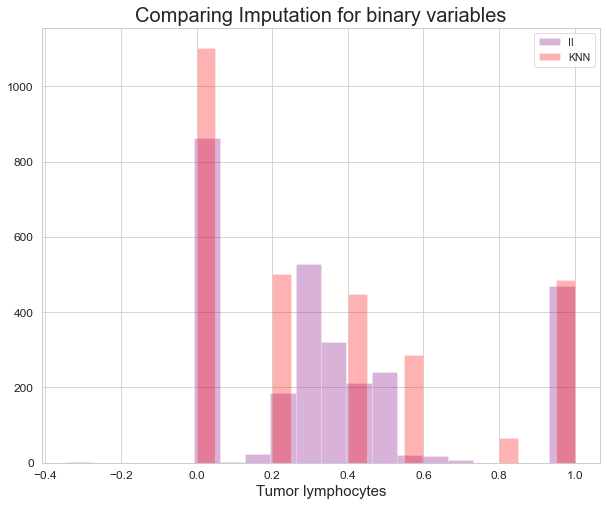

In [208]:

plt.figure(figsize = (10,8))
plt.hist(II_imputed_df1.tumor_lymphocytes, bins = 20,
         facecolor = "purple", alpha = 0.3, label = "II")
plt.hist(KNN_imputed_df1.tumor_lymphocytes, bins = 20,
         facecolor = "red", alpha = 0.3, label = "KNN")
#plt.hist(compare_imputed.KNNImputer,facecolor = "yellow", alpha = 0.3, label = "KNN")
plt.title("Comparing Imputation for binary variables", size = 20)
plt.legend(loc = "upper right")
plt.xlabel("Tumor lymphocytes", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

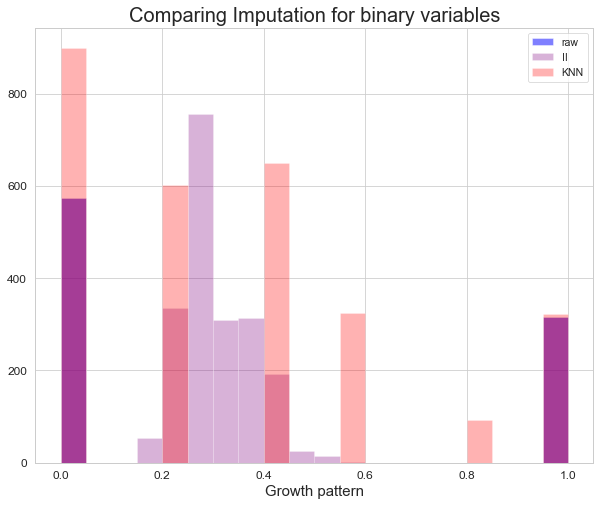

In [209]:

plt.figure(figsize = (10,8))
plt.hist(df1.growth_pattern, bins = 20, 
        facecolor = "blue", alpha =0.5, label = "raw")
plt.hist(II_imputed_df1.growth_pattern, bins = 20,
         facecolor = "purple", alpha = 0.3, label = "II")
plt.hist(KNN_imputed_df1.growth_pattern, bins = 20,
         facecolor = "red", alpha = 0.3, label = "KNN")
plt.title("Comparing Imputation for binary variables", size = 20)
plt.legend(loc = "upper right")
plt.xlabel("Growth pattern", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

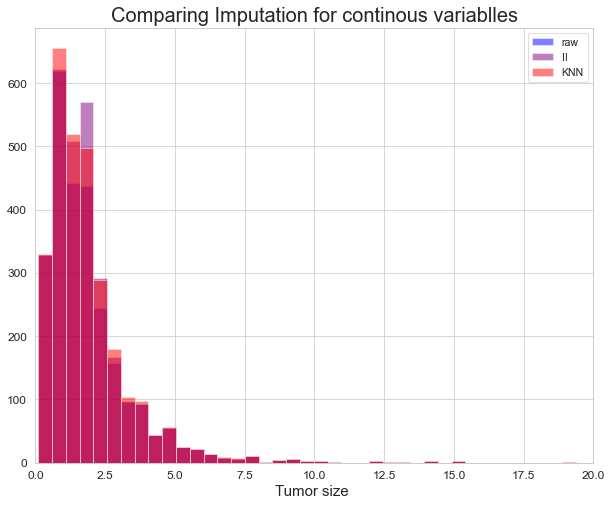

In [210]:
plt.figure(figsize = (10,8))
plt.hist(df1.tumor_size, bins = 200, 
        facecolor = "blue", alpha = 0.5, label = "raw")
plt.hist(II_imputed_df1.tumor_size, bins = 200,
         facecolor = "purple", alpha = 0.5, label = "II")
plt.hist(KNN_imputed_df1.tumor_size, bins = 200,
         facecolor = "red", alpha = 0.5, label = "KNN")
plt.title("Comparing Imputation for continous variablles", size = 20)
plt.legend(loc = "upper right")
plt.xlabel("Tumor size ", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(0, 20)
plt.show()



TypeError: _bivariate_kdeplot() got multiple values for argument 'x'

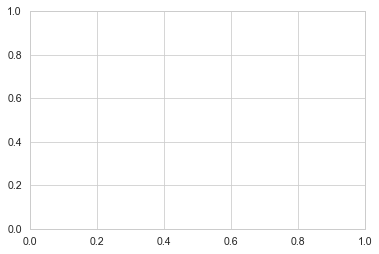

In [113]:

#sns.kdeplot(data = df1, x = "tumor_size")


### Binarize values in imputed datasets 
- using iterative imputation for predictions. 

In [211]:
II_imputed_df1['tumor_lymphocytes'] = II_imputed_df1.tumor_lymphocytes.\
apply(lambda x : 1 if x > 0.5 else 0)
II_imputed_df1.tumor_lymphocytes.value_counts()

0    2310
1     577
Name: tumor_lymphocytes, dtype: int64

In [212]:
II_imputed_df1['growth_pattern'] = II_imputed_df1.growth_pattern.\
apply(lambda x : 1 if x > 0.5 else 0)
II_imputed_df1.growth_pattern.value_counts()

0    2557
1     330
Name: growth_pattern, dtype: int64

In [213]:
II_imputed_df2['tumor_lymphocytes'] = II_imputed_df2.tumor_lymphocytes.\
apply(lambda x : 1 if x > 0.5 else 0)
II_imputed_df2.tumor_lymphocytes.value_counts()

0    5475
1     726
Name: tumor_lymphocytes, dtype: int64

In [214]:
II_imputed_df2['lymph_vasc_invasion'] = II_imputed_df2.lymph_vasc_invasion.\
apply(lambda x : 1 if x > 0.5 else 0)
II_imputed_df2.lymph_vasc_invasion.value_counts()

0    5181
1    1020
Name: lymph_vasc_invasion, dtype: int64

In [215]:
df1_complete.to_csv("../data/processed/NCDB_with_growth_complete.csv")
df2_complete.to_csv("../data/processed/NCDB_without_growth_complete.csv")
II_imputed_df1.to_csv("../data/processed/NCDB_with_growth_IterativeImputed.csv")
II_imputed_df2.to_csv("../data/processed/NCDB_without_growth_IterativeImputed.csv")
